Created on Tue Oct 31 09:31:24 2023

@author: Santiago D'hers

Use:

- This script will compare manual labels, geolabels and autolabels

Requirements:

- The position.csv files processed by 1-Manage_H5.py
- Geolabels, autolabels and manual labels

In [25]:
import os
from glob import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import random

In [26]:
class Point:
    def __init__(self, df, table):

        x = df[table + '_x']
        y = df[table + '_y']

        self.positions = np.dstack((x, y))[0]

    @staticmethod
    def dist(p1, p2):
        return np.linalg.norm(p1.positions - p2.positions, axis=1)

class Vector:
    def __init__(self, p1, p2, normalize=True):

        self.positions = p2.positions - p1.positions

        self.norm = np.linalg.norm(self.positions, axis=1)

        if normalize:
            self.positions = self.positions / np.repeat(np.expand_dims(self.norm,axis=1), 2, axis=1)

    @staticmethod
    def angle(v1, v2):
        
        length = len(v1.positions)
        angle = np.zeros(length)

        for i in range(length):
            angle[i] = np.rad2deg(np.arccos(np.dot(v1.positions[i], v2.positions[i])))

        return angle

In [27]:
# State your path:
path = r'C:/Users/dhers/OneDrive - UBA/workshop'
experiment = r'Ultron'

TS_position = glob(os.path.join(path, experiment,"TS/position/*position.csv"))

TS_labels = glob(os.path.join(path, experiment,"TS/labels/*labels.csv"))
TS_geolabels = glob(os.path.join(path, experiment,"TS/geolabels/*labels.csv"))
TS_autolabels = glob(os.path.join(path, experiment,"TS/autolabels/*labels.csv"))

In [28]:
# Select one video to use as example

video = random.randint(1, len(TS_position)) # Select the number of the video you want to use
video_name = os.path.basename(TS_position[video - 1]).replace("_position.csv", "")

position = pd.read_csv(TS_position[video - 1])
labels = pd.read_csv(TS_labels[video - 1])
geolabels = pd.read_csv(TS_geolabels[video - 1])
autolabels = pd.read_csv(TS_autolabels[video - 1])

print(f'Using {video_name} as an example')

Using 2023-05_TeNOR_TS_C2_B_L as an example


To start comparing labels, we will plot the time series corresponding to the video, indicating the predictions made by the geometric algorithm and manually.

We will also plot the distance and angle from the mouse to each object, in order to relate their minima to the predictions made by our custom algorithm.

In [29]:
len_dif = len(labels) - len(geolabels)
labels = labels.iloc[len_dif:].reset_index(drop=True)

In [30]:
def plot_timeline(position, labels, geolabels, autolabels):
    
    # Extract positions of both objects and bodyparts
    obj1 = Point(position, 'obj_1')
    obj2 = Point(position, 'obj_2')
    nose = Point(position, 'nose')
    head = Point(position, 'head')
    
    # Find distance from the nose to each object
    dist1 = Point.dist(nose, obj1)
    dist2 = Point.dist(nose, obj2)
    
    # Compute normalized head-nose and head-object vectors
    head_nose = Vector(head, nose, normalize = True)
    head_obj1 = Vector(head, obj1, normalize = True)
    head_obj2 = Vector(head, obj2, normalize = True)
    
    # Find the angles between the head-nose and head-object vectors
    angle1 = Vector.angle(head_nose, head_obj1) # deg
    angle2 = Vector.angle(head_nose, head_obj2) # deg

    """
    Plot
    """
    
    # Set start and finish frames
    a, b = 0, -1
    
    plt.figure(figsize = (16, 6))
    
    # Exploration on obj_1 
    plt.plot(labels["obj_1"][a:b] * 4, ".", color = "black", label = "Manual")
    plt.plot(geolabels["obj_1"][a:b] * 3, ".", color = "blue", label = "Geometric")
    
    # Exploration on obj_2
    plt.plot(labels["obj_2"][a:b] * -4, ".", color = "black")
    plt.plot(geolabels["obj_2"][a:b] * -3, ".", color = "blue")
    
    # Add the rectangle to the plot
    plt.gca().add_patch(plt.Rectangle((-10,-1), 7520, 2, color='white', ec='none', zorder=2))
    
    # Autolabels
    plt.plot(autolabels["obj_1"][a:b] * 2, color = "red", label = "Automatic")    
    plt.plot(autolabels["obj_2"][a:b] * -2, color = "red")
    
    # Plot distance and orientation to object 1
    plt.plot(angle1[a:b] + 6, color = "grey", label = "Orientation to 1 (deg)")
    plt.plot(dist1[a:b] + 6, color = "black", label = "Distance to 1 (cm)" )
    
    # Plot distance and orientation to object 2
    plt.plot(angle2[a:b]*(-1) - 6, color = "lightgreen", label = "Orientation to 2 (deg)")
    plt.plot(dist2[a:b]*(-1) - 6, color = "darkgreen", label = "Distance to 2 (cm)")
    
    # Zoom in on some frames
    # plt.xlim((1200, 2250))
    
    # Zoom in on the labels and the minima of the distances and angles
    plt.ylim((-20, 20))
    
    plt.xlabel("Frame number")
    plt.legend(loc='upper left', fancybox=True, shadow=True)
    
    # plt.suptitle(f"Analysis of {video_name}", y=0.98)
    plt.suptitle("Manual, geometric and automatic labels along with distance & angle of approach", y=0.95)
    plt.tight_layout()
    plt.show()

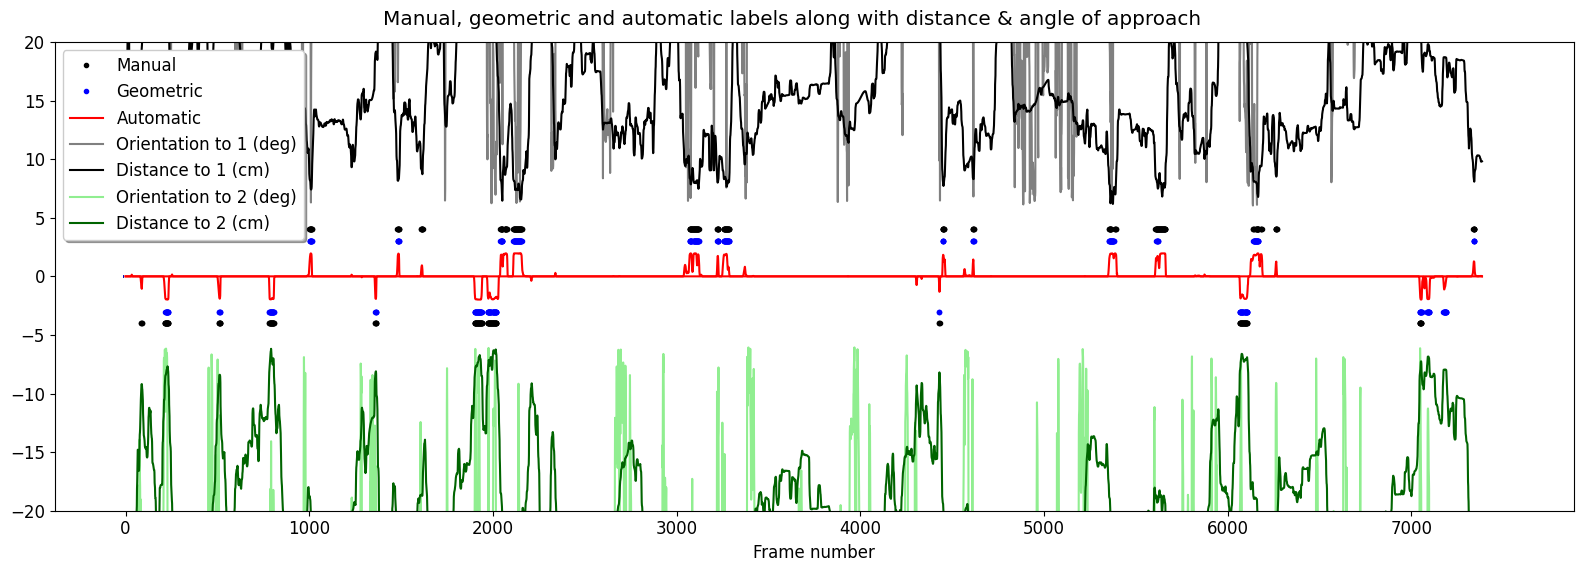

In [31]:
plot_timeline(position, labels, geolabels, autolabels)

In [32]:
def polar_graph(position, label_1, label_2, obj_1 = "obj_1", obj_2 = "obj_2"):
    
    # Extract positions of both objects and bodyparts
    obj1 = Point(position, 'obj_1')
    obj2 = Point(position, 'obj_2')
    nose = Point(position, 'nose')
    head = Point(position, 'head')
    
    # Find distance from the nose to each object
    dist1 = Point.dist(nose, obj1)
    dist2 = Point.dist(nose, obj2)
    
    # Compute normalized head-nose and head-object vectors
    head_nose = Vector(head, nose, normalize = True)
    head_obj1 = Vector(head, obj1, normalize = True)
    head_obj2 = Vector(head, obj2, normalize = True)
    
    # Find the angles between the head-nose and head-object vectors
    angle1 = Vector.angle(head_nose, head_obj1) # deg
    angle2 = Vector.angle(head_nose, head_obj2) # deg

    """
    Plot
    """
    
    plt.rcParams['figure.figsize'] = [12, 6]  # Set the figure size
    plt.rcParams['font.size'] = 12
    
    # Set start and finish frames
    a, b = 0, -1
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))
    
    
    # Set title for the first subplot
    ax1.set_title(f"{obj_1}")
    
    # Determine the colors of the exploration points by the method that detected them
    colors_1 = ['red' if label >= 0.5 else 'gray' for label in label_1[f"{obj_1}"][a:b]]
    alpha_1 = [0.5 if label >= 0.5 else 0.2 for label in label_1[f"{obj_1}"][a:b]]
    
    colors_2 = ['blue' if label == 1 else 'gray' for label in label_2[f"{obj_1}"][a:b]]
    alpha_2 = [0.5 if label == 1 else 0.2 for label in label_2[f"{obj_1}"][a:b]]
    
    # Plot for the first subplot (ax1)
    c1 = ax1.scatter((angle1[a:b] + 90) / 180 * np.pi, dist1[a:b], c=colors_1, s=6, alpha=alpha_1)
    c1 = ax1.scatter(-(angle1[a:b] - 90) / 180 * np.pi, dist1[a:b], c=colors_2, s=6, alpha=alpha_2)
    
    ang_plot = np.linspace(np.pi/4, np.pi / 2, 25).tolist()
    
    c1 = ax1.plot([0] + ang_plot + [0], [0] + [2.5] * 25 + [0], c="k", linestyle='dashed', linewidth=4)
    
    ax1.set_ylim([0, 4])
    ax1.set_yticks([1, 2, 3, 4])
    ax1.set_yticklabels(["1 cm", "2 cm", "3 cm", "4 cm"])
    ax1.set_xticks(
        [0, 45 / 180 * np.pi, 90 / 180 * np.pi, 135 / 180 * np.pi, np.pi, 225 / 180 * np.pi, 270 / 180 * np.pi,
         315 / 180 * np.pi])
    ax1.set_xticklabels(["  90°", "45°", "0°", "45°", "90°  ", "135°    ", "180°", "    135°"])
    
    
    # Set title for the first subplot
    ax2.set_title(f"{obj_2}")
    
    # Determine the colors of the exploration points by the method that detected them
    colors_1 = ['red' if label >= 0.5 else 'gray' for label in label_1[f"{obj_2}"][a:b]]
    alpha_1 = [0.5 if label >= 0.5 else 0.2 for label in label_1[f"{obj_2}"][a:b]]
    
    colors_2 = ['blue' if label == 1 else 'gray' for label in label_2[f"{obj_2}"][a:b]]
    alpha_2 = [0.5 if label == 1 else 0.2 for label in label_2[f"{obj_2}"][a:b]]
    
    # Plot for the second subplot (ax2) - copy content from ax1
    ax2.scatter((angle2[a:b] + 90) / 180 * np.pi, dist2[a:b], c=colors_1, s=6, alpha=alpha_1)
    ax2.scatter(-(angle2[a:b] - 90) / 180 * np.pi, dist2[a:b], c=colors_2, s=6, alpha=alpha_2)
    ax2.plot([0] + ang_plot + [0], [0] + [2.5] * 25 + [0], c="k", linestyle='dashed', linewidth=4)
    
    ax2.set_ylim([0, 4])
    ax2.set_yticks([1, 2, 3, 4])
    ax2.set_yticklabels(["1 cm", "2 cm", "3 cm", "4 cm"])
    ax2.set_xticks(
        [0, 45 / 180 * np.pi, 90 / 180 * np.pi, 135 / 180 * np.pi, np.pi, 225 / 180 * np.pi, 270 / 180 * np.pi,
         315 / 180 * np.pi])
    ax2.set_xticklabels(["  90°", "45°", "0°", "45°", "90°  ", "135°    ", "180°", "    135°"])
    
    # Create legend handles for both subplots
    legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Automatic'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Manual'),
    Line2D([0], [0], color='k', linestyle='dashed', linewidth=2, label='Geometric')]

    # Add legend to the figure
    fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1, 1))
    
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    
    # plt.suptitle(f"Analysis of {video_name}", y=0.98)
    plt.suptitle("Polar graph indicating exploration", y=0.95)
    
    # Show the figure with two subplots
    plt.show()

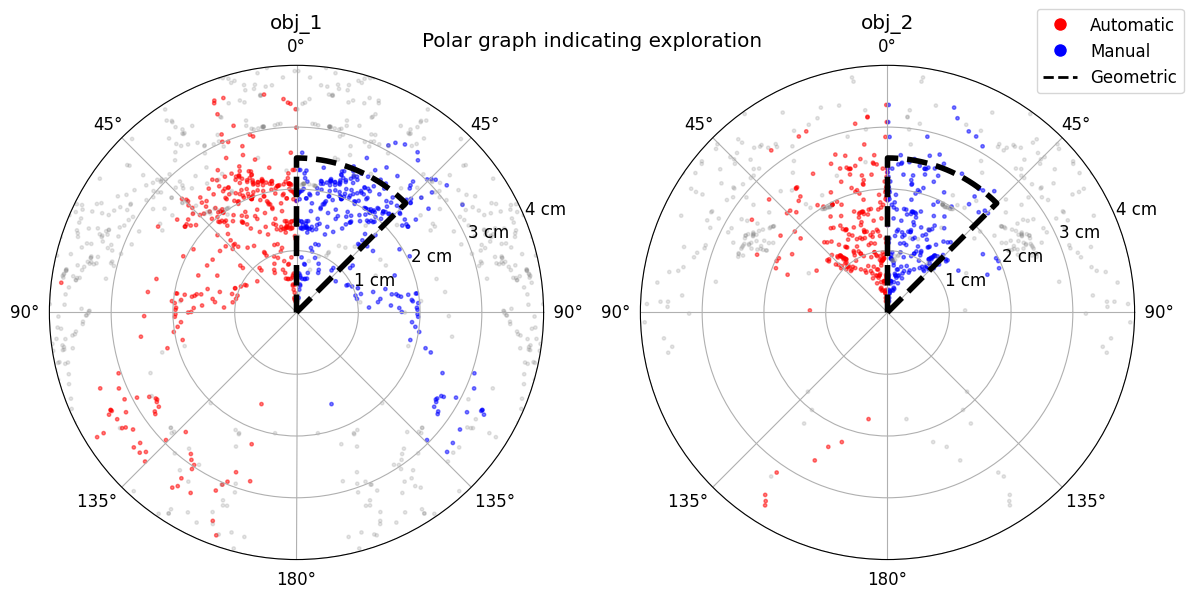

In [33]:
polar_graph(position, autolabels, labels)

In [34]:
TS_position

['C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C1_A_L_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C1_A_R_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C1_B_L_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C1_B_R_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C2_A_L_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C2_A_R_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C2_B_L_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C2_B_R_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C3_A_L_position.csv',
 'C:/Users/dhers/OneDrive - UBA/workshop\\Ultron\\TS/position\\2023-05_TeNOR_TS_C3

In [35]:
# Create an empty list to store DataFrames
for_labels = []
for_geolabels = []
for_autolabels = []
for_position = []

for i in range(len(TS_position)):

    df_position = pd.read_csv(TS_position[i])
    for_position.append(df_position)

    df_labels = pd.read_csv(TS_labels[i])
    len_dif = len(df_labels) - len(df_position)
    df_labels = df_labels.iloc[len_dif:].reset_index(drop=True)
    for_labels.append(df_labels)

    df_geolabels = pd.read_csv(TS_geolabels[i])
    for_geolabels.append(df_geolabels)

    df_autolabels = pd.read_csv(TS_autolabels[i])
    for_autolabels.append(df_autolabels)
     

# Concatenate all DataFrames into a single DataFrame
all_labels = pd.concat(for_labels, ignore_index=True)
all_geolabels = pd.concat(for_geolabels, ignore_index=True)
all_autolabels = pd.concat(for_autolabels, ignore_index=True)
all_position = pd.concat(for_position, ignore_index=True)

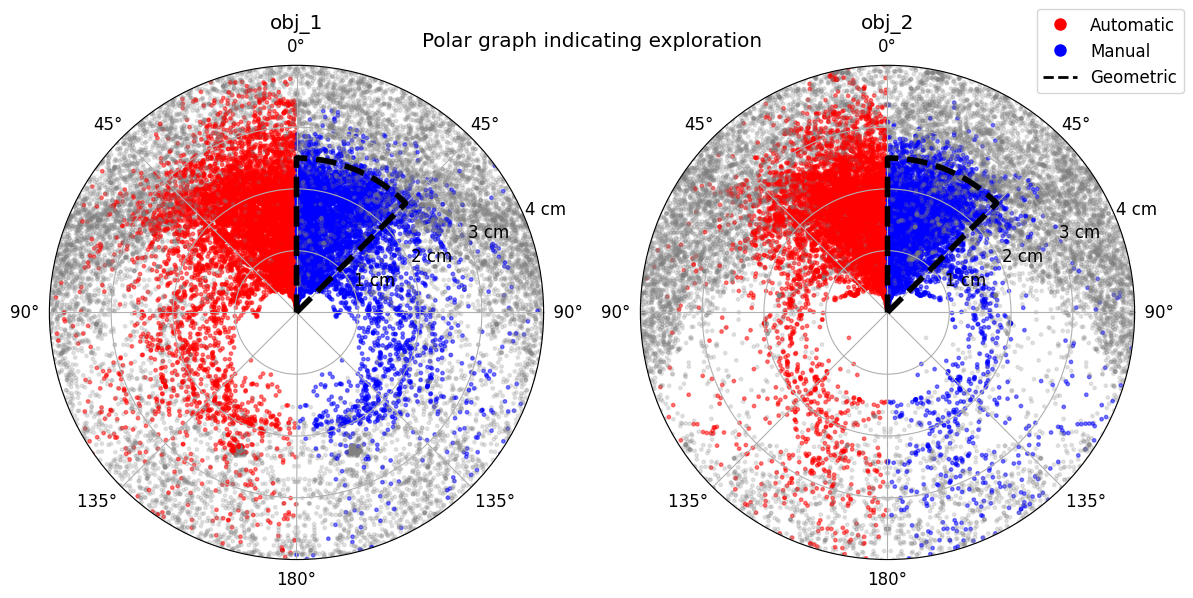

In [36]:
polar_graph(all_position, all_autolabels, all_labels)

In [37]:
def accuracy_scores(reference, compare, method):
    
    events = 0
    detected = 0
    sum_correct = 0
    sum_error = 0
    sum_false = 0

    for i in range(len(reference)):

        if reference["obj_1"][i] > 0.5: # Count the total events of exploration
            events += 1
        if compare["obj_1"][i] > 0.5: # Count the total events of exploration
            detected += 1
        if reference["obj_1"][i] > 0.5 and compare["obj_1"][i] > 0.5: # Correct 
            sum_correct += 1
        if reference["obj_1"][i] > 0.5 and compare["obj_1"][i] < 0.5: # False negative
            sum_error += 1
        if reference["obj_1"][i] < 0.5 and compare["obj_1"][i] > 0.5: # False positive
            sum_false += 1
            
    for i in range(len(reference)):
        
        if reference["obj_2"][i] > 0.5: # Count the total events of exploration
            events += 1
        if compare["obj_2"][i] > 0.5: # Count the total events of exploration
            detected += 1
        if reference["obj_2"][i] > 0.5 and compare["obj_2"][i] > 0.5: # Correct 
            sum_correct += 1
        if reference["obj_2"][i] > 0.5 and compare["obj_2"][i] < 0.5: # False negative
            sum_error += 1
        if reference["obj_2"][i] < 0.5 and compare["obj_2"][i] > 0.5: # False positive
            sum_false += 1
    
    print(f"Mice explored {(events/len(reference))*100}% of the time.")
    print(f"The {method} method measured {(detected/len(reference))*100}% of the time as exploration.")
    print(f"It got {(sum_error/events)*100}% of false negatives and {(sum_false/events)*100}% of false positives.")

In [38]:
# Create a new dataframe from the merge of both
all_merge = pd.DataFrame(index=all_autolabels.index)
all_merge['Frame'] = all_geolabels['Frame']
all_merge['obj_1'] = ((all_geolabels['obj_1'] >= 0.5) & (all_autolabels['obj_1'] >= 0.5)).astype(int)
all_merge['obj_2'] = ((all_geolabels['obj_2'] >= 0.5) & (all_autolabels['obj_2'] >= 0.5)).astype(int)

In [39]:
print(f"In {experiment}:")
accuracy_scores(all_labels, all_geolabels, "geometric")
accuracy_scores(all_labels, all_autolabels, "automatic")
accuracy_scores(all_labels, all_merge, "merge")

In Ultron:
Mice explored 8.627888877609719% of the time.
The geometric method measured 7.95316888302372% of the time as exploration.
It got 26.331476978586554% of false negatives and 18.51125578476743% of false positives.
Mice explored 8.627888877609719% of the time.
The automatic method measured 11.14404628971678% of the time as exploration.
It got 8.620283943838732% of false negatives and 38.01866813083379% of false positives.
Mice explored 8.627888877609719% of the time.
The merge method measured 7.603965756437586% of the time as exploration.
It got 28.010040003137497% of false negatives and 16.142442544513294% of false positives.
